In [1]:
%reload_ext autoreload
%autoreload 2

In [24]:
from datetime import datetime, timedelta
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#from pypfopt.cla import CLA
#from pypfopt.efficient_frontier import EfficientFrontier
#from pypfopt.expected_returns import mean_historical_return
#from pypfopt.risk_models import CovarianceShrinkage
import yfinance as yf

sys.path.append('..')#, '../pypfopt_local/pypfopt'])
from util.batcher import Batcher
from pypfopt_local.pypfopt.expected_returns import (
    mean_historical_return)
from pypfopt_local.pypfopt.risk_models import CovarianceShrinkage
#from util.stock_loader import Loader

In [2]:
TODAY = (datetime.now() + timedelta(1)).date()
YEARS_OF_DATA = 10
START = TODAY - timedelta(YEARS_OF_DATA * 365)
START, TODAY

(datetime.date(2012, 8, 15), datetime.date(2022, 8, 13))

In [3]:
sharpes = pd.read_csv('sharpes.csv')
sharpes.head()

,stock,sharpe
0,ASAN,4.146624
1,efc,3.530101
2,stry,3.398456
3,lly,3.048137
4,eve,2.531150


<a href="https://www.advfn.com/nasdaq/nasdaq.asp?companies=A">Nasdaq listings</a>

In [8]:
#KEEP_TOP_N = 50
sym = (
    'alsk tcrt amri afbk alac albo abdc duck aldr aldx alec alr alrs alxn '
    'astl alco algn alhc algs alim alya wter alkt alks aiki kuri allk '
    'allr bird abtx algx algt algr algm alna abva afop alnc lnt aese ahci '
    'ahpi amot alli alqa alvr allo alth allt aloy mdrx afam alny aspc '
    'shac alpa aptm alsa drts tkno aosl goog alsm atec alpp reve alpn '
)
missing = (
    'amri afop alli aloy algr alac  alsk kuri ahci alqa duck afbk abdc algx '
    'aldr alsm alxn'
)
SYMBOLS = [s for s in sym.split() if s not in missing.split()]
#SYMBOLS

In [9]:
data = (
    yf.download(SYMBOLS, start=START, end=TODAY)
    .rename(columns={'Adj Close': 'AdjClose'}))['AdjClose']
data.columns = SYMBOLS
data.head()

[*********************100%***********************]  50 of 50 completed


,tcrt,albo,aldx,alec,alr,alrs,astl,alco,algn,alhc,...,aptm,alsa,drts,tkno,aosl,goog,atec,alpp,reve,alpn
Date,,,,,,,,,,,,,,,,,,,,,
2012-08-15,NaN,4.40,NaN,19.916016,5.6,11608.265625,92.400002,25.767624,NaN,NaN,...,NaN,NaN,16.626181,16.743404,11.46,NaN,NaN,5.17,NaN,NaN
2012-08-16,NaN,4.40,NaN,19.734465,5.6,12349.218750,92.699997,25.862452,NaN,NaN,...,NaN,NaN,16.758932,16.663794,11.58,NaN,NaN,5.15,NaN,NaN
2012-08-17,NaN,4.47,NaN,19.888783,5.6,11855.250000,92.699997,27.138332,NaN,NaN,...,NaN,NaN,16.865286,16.642086,11.33,NaN,NaN,5.12,NaN,NaN
2012-08-20,NaN,4.48,NaN,20.206493,5.2,11855.250000,90.599998,27.121092,NaN,NaN,...,NaN,NaN,16.825434,16.562475,11.01,NaN,NaN,5.15,NaN,NaN
2012-08-21,NaN,4.40,NaN,20.170183,5.2,11855.250000,90.599998,26.465902,NaN,NaN,...,NaN,NaN,16.675247,16.500957,10.89,NaN,NaN,5.08,NaN,NaN


In [10]:
def get_daily_returns(x):
    n = len(x)
    x = np.array(x)
    return x[2:n] / x[1:(n - 1)] - 1 

In [11]:
def get_sharpe(returns, window=None):
    n = len(returns)
    if window is None:
        window = n
    if len(returns) > window:
        returns = returns[(n - window):n]
    returns = returns[~np.isnan(returns)]
    sharpe = (np.sqrt(252) * returns.mean()) / returns.std()
    return sharpe

In [12]:
new_sharpes = []
for stock in SYMBOLS:
    sharpe = get_sharpe(get_daily_returns(data[stock]))
    new_sharpes.append([stock, sharpe])

In [13]:
sharpe_df = (
    pd.DataFrame(new_sharpes, columns=['stock', 'sharpe'])
    .sort_values('sharpe', ascending=False))
sharpe_df.head(15)

,stock,sharpe
31,allo,8.704763
23,alna,1.927895
30,alvr,1.900950
27,aese,1.171419
42,drts,0.889079
1,albo,0.880756
45,goog,0.843109
43,tkno,0.766241
24,abva,0.729997
11,alim,0.706145


In [14]:
sharpes_df = (
    pd.concat([sharpes, sharpe_df])
    .sort_values('sharpe', ignore_index=True, ascending=False)
    .drop_duplicates())
sharpes_df.drop_duplicates(subset=['stock'], inplace=True)
sharpes_df.index = sharpes_df['stock']
sharpes_df.drop(columns=['stock'], inplace=True)

sharpes_df.head(20)

,sharpe
stock,
allo,8.704763
ASAN,4.146624
efc,3.530101
stry,3.398456
lly,3.048137
eve,2.531150
chmt,2.475858
hhs,2.406309
bxsl,2.249160


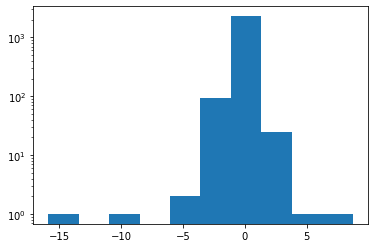

In [15]:
plt.hist(sharpes_df.sharpe)
plt.yscale('log');

In [16]:
sharpes.loc[sharpes.stock == 'sfg', :]

,stock,sharpe


In [17]:
omit = 'dcue'
inds = []
for o in omit.split():
    inds += (sharpes.loc[sharpes.stock == o, :].index.tolist())

sharpes.drop(index=inds, inplace=True)

In [18]:
sharpes.to_csv('sharpes.csv', index=False)

In [19]:
sharpes.shape

(2652, 2)

In [20]:
MIX = sharpes.stock.unique().tolist()[:400]
len(MIX)
df = yf.download(MIX, start=START, end=TODAY)
df.drop(
    columns=['Open', 'Close', 'Volume', 'High', 'Low'], inplace=True)
print(df.shape)
df.head()

[*********************100%***********************]  400 of 400 completed
(2517, 400)


Adj Close                                                     \
                  ABC      ABEV        ABM ACA      ACRE ADCT        ADM   
Date                                                                       
2012-08-15  32.430428  4.500563  15.744121 NaN  7.043868  NaN  20.106295   
2012-08-16  32.055126  4.535701  16.320921 NaN  6.997308  NaN  20.159910   
2012-08-17  32.132130  4.484458  16.564638 NaN  6.938043  NaN  20.045019   
2012-08-20  32.277653  4.484458  16.621506 NaN  6.950741  NaN  20.305441   
2012-08-21  32.149254  4.349763  16.629629 NaN  6.950741  NaN  20.159910   

                                            ...                            \
                 AEG        AEL        AEO  ... WDH       WLYB        WMT   
Date                                        ...                             
2012-08-15  3.399658  10.340819  14.748468  ... NaN  37.162724  59.521385   
2012-08-16  3.507113  10.404428  14.790352  ... NaN  37.380772  57.682579   
2012-08-17  3.487336  10.458949  14.685651  ... NaN  37.380772  57.554665   
2012-08-20  3.408228  10.631598  14.273833  ... NaN  37.544304  57.802509   
2012-08-21  3.460967  10.677034  14.539073  ... NaN  37.536518  57.106964   

                                                                
           WNNR WPCA        WRE        WSO        XOM XPOA YOU  
Date                                                            
2012-08-15  NaN  NaN  17.164845  51.108692  57.720940  NaN NaN  
2012-08-16  NaN  NaN  17.223299  52.014225  58.160408  NaN NaN  
2012-08-17  NaN  NaN  17.262262  52.968868  57.983299  NaN NaN  
2012-08-20  NaN  NaN  17.262262  52.996941  57.688148  NaN NaN  
2012-08-21  NaN  NaN  17.210314  53.032032  57.366734  NaN NaN  

[5 rows x 400 columns]

In [21]:
df.columns = MIX
MAX_MISSING = 30
n_nan = df.isnull().sum()
n_nan
drop = n_nan[n_nan > MAX_MISSING].index
df = df.drop(columns=drop)
print(df.shape)
df.head()

(2517, 230)


,ASAN,efc,stry,eve,hhs,bxsl,dwin,swi,pnw,irs,...,hr,mixt,thr,tinv,ohi,jbgs,cni,rcc,cah,tslx
Date,,,,,,,,,,,,,,,,,,,,,
2012-08-15,32.430428,4.500563,15.744121,7.043868,20.106295,3.399658,10.340819,14.748468,16.958141,5.155486,...,30.087740,7.610584,8.524117,37.973080,11.186957,37.162724,59.521385,17.164845,51.108692,57.720940
2012-08-16,32.055126,4.535701,16.320921,6.997308,20.159910,3.507113,10.404428,14.790352,17.476860,5.164251,...,30.232283,7.606179,8.592580,38.626549,10.995806,37.380772,57.682579,17.223299,52.014225,58.160408
2012-08-17,32.132130,4.484458,16.564638,6.938043,20.045019,3.487336,10.458949,14.685651,17.446932,5.076573,...,30.001482,7.601771,8.575463,38.531155,11.159648,37.380772,57.554665,17.262262,52.968868,57.983299
2012-08-20,32.277653,4.484458,16.621506,6.950741,20.305441,3.408228,10.631598,14.273833,17.995581,5.129182,...,29.877928,7.628196,8.575463,38.244965,11.250672,37.544304,57.802509,17.262262,52.996941,57.688148
2012-08-21,32.149254,4.349763,16.629629,6.950741,20.159910,3.460967,10.677034,14.539073,18.554203,5.137949,...,29.728720,7.654624,8.746633,38.893677,11.341699,37.536518,57.106964,17.210314,53.032032,57.366734


In [22]:
#import cvxpy
#cvxpy.installed_solvers()

In [25]:
mu = mean_historical_return(df)
s = CovarianceShrinkage(df).ledoit_wolf()
#ef = EfficientFrontier(mu, s, solver='ECOS')# , verbose=True)
#weights = ef.max_sharpe()
#cleaned_weights = ef.clean_weights()
#for k, v in dict(cleaned_weights).items():
#    if v > 0:
#        print(f'{k:6s}: {v}')

In [22]:
ret, vol, sh = ef.portfolio_performance(verbose=True)

Expected annual return: 21.9%
Annual volatility: 12.9%
Sharpe Ratio: 1.54


In [23]:
ret, sh

(0.2193182094445824, 1.5415034786689372)

In [24]:
vol = np.linspace(0.10, 0.30, 50)
rets = []
sharpes = []
for v in vol:
    print(f'Vol: {v}   ', end='\r')
    ef = EfficientFrontier(mu, s, solver='ECOS')
    w = ef.efficient_risk(target_volatility=v)
    r, _, sh = ef.portfolio_performance()
    rets.append(r)
    sharpes.append(sh)

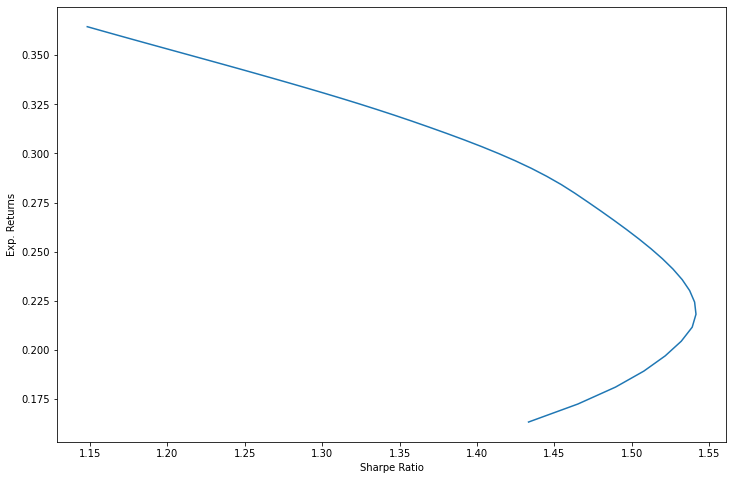

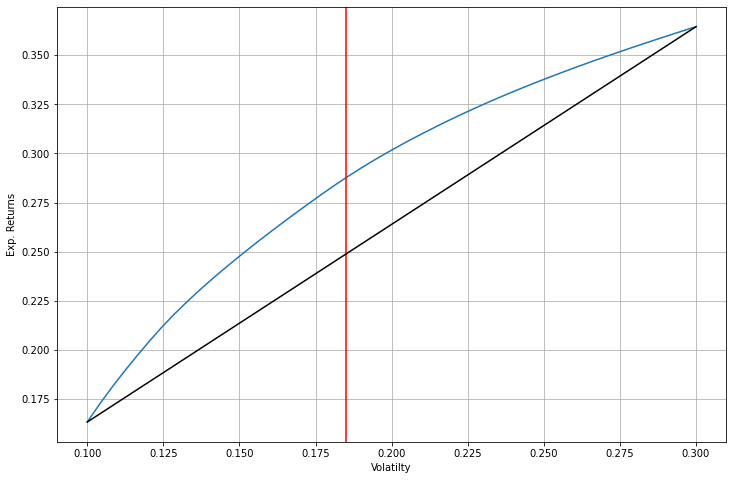

In [25]:
plt.figure(figsize=[12,8])
plt.plot(sharpes, rets)
plt.xlabel('Sharpe Ratio')
plt.ylabel('Exp. Returns');

plt.figure(figsize=[12,8])
plt.plot(vol, rets)
plt.grid(True)
plt.axvline(x=0.185, color='r')
plt.plot([0.1, 0.3], [rets[0], rets[-1]], color='k')
plt.xlabel('Volatilty')
plt.ylabel('Exp. Returns');

In [26]:
OPTIMAL_VOL = 0.185
ef = EfficientFrontier(mu, s, solver='ECOS')
weights = ef.efficient_risk(target_volatility=OPTIMAL_VOL)
cleaned_weights = dict(ef.clean_weights())
weights = {k: v for k, v in cleaned_weights.items() if v > 0}
for k, v in weights.items():
    print(f'{k:6s}: {v}')

fmc   : 0.03498
hrl   : 0.01714
cmcm  : 0.00127
sxt   : 0.07195
trv   : 0.00079
hmn   : 0.17209
kar   : 0.02961
fif   : 0.10252
eqgp  : 0.0442
dma   : 0.01662
msge  : 0.23477
gcv   : 0.23629
rc    : 0.0282
ohi   : 0.00957


In [27]:
ret, vol, sh = ef.portfolio_performance(verbose=True)

Expected annual return: 28.8%
Annual volatility: 18.5%
Sharpe Ratio: 1.45


In [28]:
ret, sh

(0.28764331792054115, 1.446720637003597)

In [29]:
sharpes_df.loc[weights.keys(), 'sharpe']

stock
fmc     1.546894
hrl     1.320501
cmcm    1.010863
sxt     0.992081
trv     0.913207
hmn     0.770981
kar     0.766604
fif     0.740030
eqgp    0.735395
dma     0.695828
msge    0.664737
gcv     0.663361
rc      0.660977
ohi     0.651541
Name: sharpe, dtype: float64